# Table of content
- **Introduction**
- **Model building, training and testing**

    - *Model building*
    - *Model training*
    - *Model testing*
- **Results**
    - *Accuracy*
    - *Recall score*
    - *Loss curve*
    - *Classification report*

- **Conclusion**

# Introduction 
This project is about creating an algorithm that would predict the detection of lung cancer based on CT scans. The algorithm would also predict what type of cancer is within the patient and the size of the tumor if applied.

In [1]:
# Read the stored binary dataframe
%store -r df_lungs_binary

In [1]:
# Import the necessary modules
# If you get a ModuleNotFoundError, use %pip install {module} to install the module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydicom as dicom
from pathlib import Path
import time
from zipfile import ZipFile 
import cv2
from tqdm import tqdm
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, recall_score, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import xmltodict
import functions_project
from sklearn.preprocessing import LabelBinarizer

Functions import succesfull


# Model building, training and testing
In this chapter, the model will be build and trained before it will be tested among the test data.


In [26]:
# Split the data for the binary classification using train_test_split
x_binary = np.array([np.array(val) for val in df_lungs_binary.image_pixels])
y_binary = df_lungs_binary.has_cancer

X_train, X_test, y_train, y_test = train_test_split(x_binary, y_binary, test_size = 0.35, random_state = 42)

# Create the Dataset object to make it ready for the Neural Network
train_ds = Dataset.from_tensor_slices((X_train, y_train))
test_ds = Dataset.from_tensor_slices((X_test, y_test))

## Model building

In [72]:
# Set input parameters for binary classification
model_name_binary = "CNN_model_binary"
input_shape_binary = (512, 512)
filters_binary = [512, 256]
metrics_binary = ['accuracy', tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")]
loss_binary = 'binary_crossentropy'
optimizer_binary = 'adam'
lr_binary = 0.001

epochs_binary = 30
batch_size_binary = 6
steps_per_epcoh_binary = 4
patience_binary = 5
monitor_bin = 'val_accuracy'

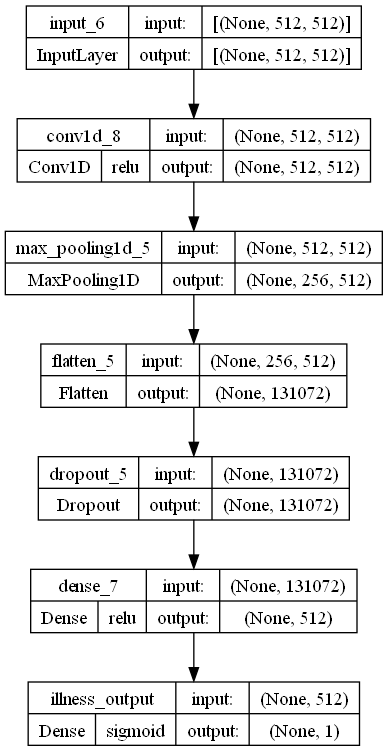

In [73]:
model_binary = functions_project.create_binary_model(model_name_binary, inputShape = input_shape_binary, filters = filters_binary)

# Plot the model using the plot_model function
plot_model(model_binary, model_name_binary + ".png", show_shapes=True, show_layer_activations = True)

## Model training

In [74]:
# Train on the binary model
hist_bin = functions_project.train_model(model_binary, metrics_binary, loss_binary, optimizer_binary, monitor_bin, train_ds, test_ds, 
                   epochs_binary, batch_size_binary, steps_per_epcoh_binary, patience_binary)

Epoch 1/30
4/4 [==============================] - 9s 2s/step - loss: 40437.3633 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - val_loss: 2128.2471 - val_accuracy: 0.4615 - val_precision: 0.4615 - val_recall: 1.0000
Epoch 2/30
4/4 [==============================] - 5s 1s/step - loss: 1980.9528 - accuracy: 0.3750 - precision: 0.3182 - recall: 1.0000 - val_loss: 1417.9663 - val_accuracy: 0.8531 - val_precision: 1.0000 - val_recall: 0.6818
Epoch 3/30
4/4 [==============================] - 5s 1s/step - loss: 2856.2314 - accuracy: 0.8333 - precision: 1.0000 - recall: 0.7143 - val_loss: 100.2623 - val_accuracy: 0.8182 - val_precision: 0.7174 - val_recall: 1.0000
Epoch 4/30
4/4 [==============================] - 5s 1s/step - loss: 428.3189 - accuracy: 0.7500 - precision: 0.7143 - recall: 1.0000 - val_loss: 485.1430 - val_accuracy: 0.7692 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/30
4/4 [==============================] - 5s 1s/step - loss: 136.8586 - accuracy: 0.9167 - pre

## Model testing

In [85]:
pred_nn = model_binary.predict(test_ds.batch(32))

# # Get predicted outputs
preds = []

for i in range(pred_nn.shape[0]):
    data = pred_nn[i]
    
    if data < 1:
        preds.append(0)
    else:
        preds.append(1)



5/5 [==============================] - 2s 361ms/step


# Results
In this chapter, the results will be shown. For this, we'll look into the following:
- The True Negative Rate for detecting the lung cancer
- The Mean Absolute Error (MAE) for the size of the tumor
- Accuracy for the type of cancer and the corresponding confidence score.

## Results binary neural network
In this paragraph, the results of the binary neural network will be shown.

### Accuracy

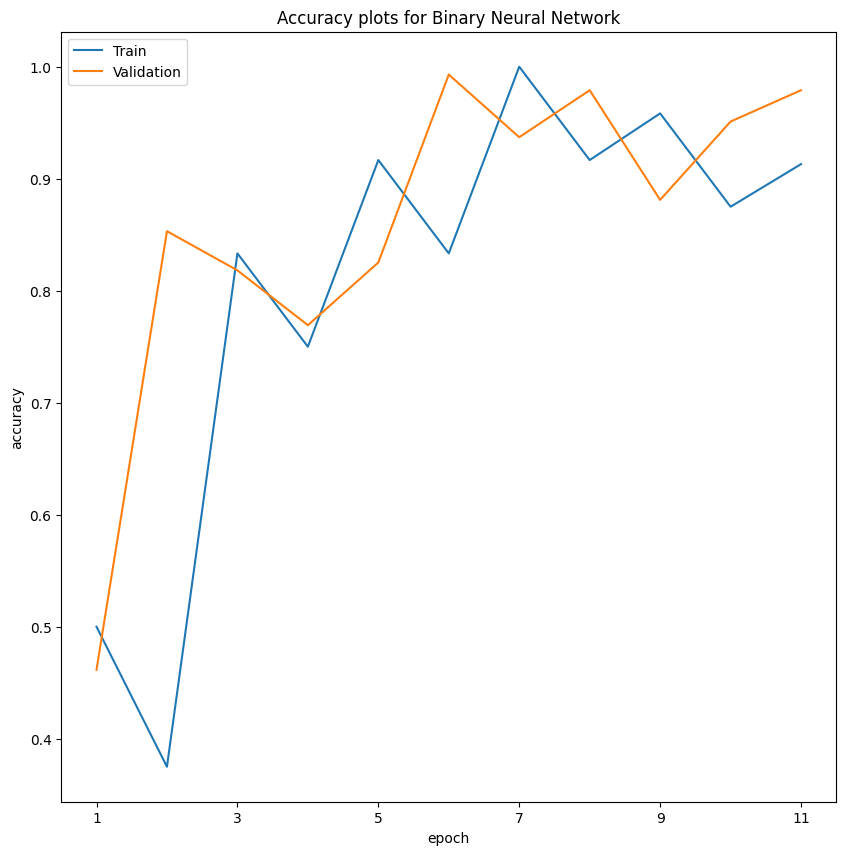

In [87]:
# Set parameters for accuracy plots
y_acc = hist_bin.history['accuracy']
y_val_acc = hist_bin.history['val_accuracy']
title_bin = "Accuracy plots for Binary Neural Network"
ylabel = "accuracy"
figsize_bin = (10, 10)

# summarize history for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_acc, y_val_acc, title_bin, ylabel, figsize_bin)

### Recall score

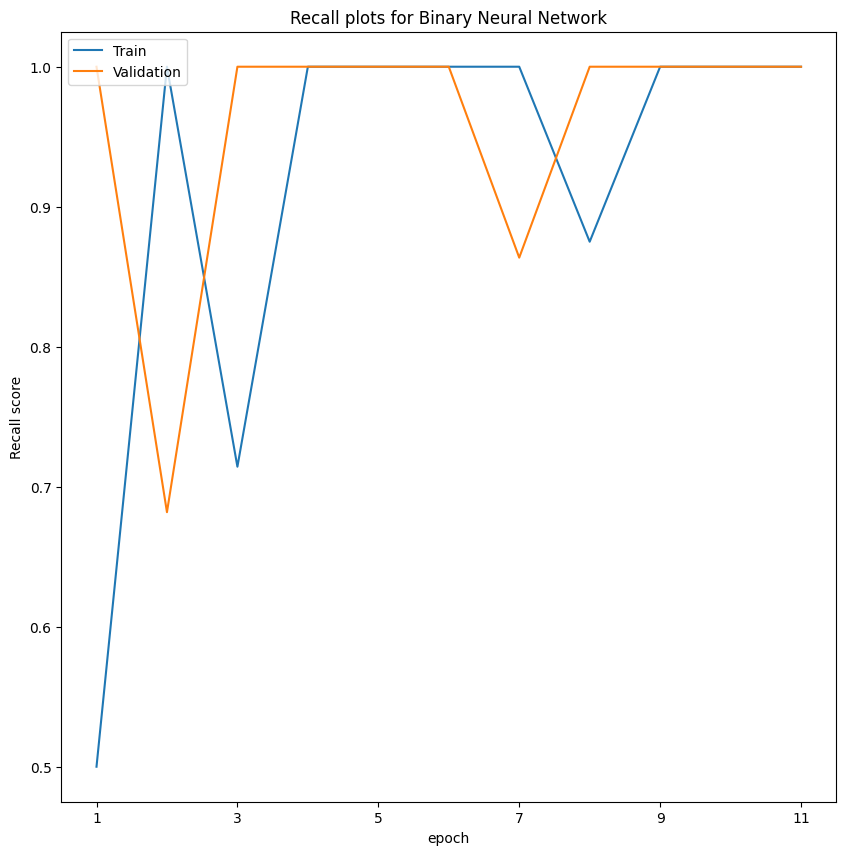

In [88]:
# Display the recall curve
# Set the parameters
y_rec = hist_bin.history['recall']
y_val_rec = hist_bin.history['val_recall']
title_bin_rec = "Recall plots for Binary Neural Network"
ylabel = "Recall score"
figsize_bin = (10, 10)

# summarize history for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_rec, y_val_rec, title_bin_rec, ylabel, figsize_bin)

In [89]:
recall = recall_score(preds, y_test)

print(f"Recall score of binary Neural Network: {recall:.2f}")

Recall score of binary Neural Network: 0.96


### Confusion matrix

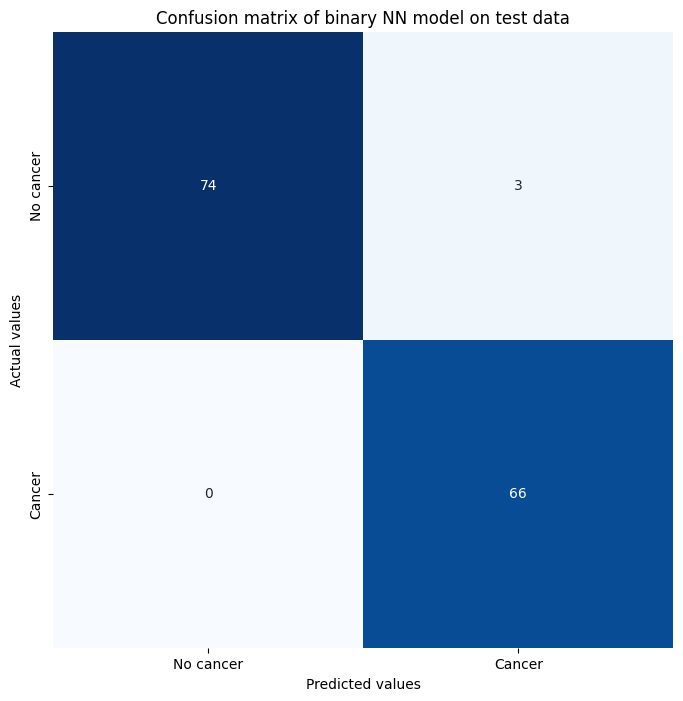

In [90]:
labels_binary_nn = ["No cancer", "Cancer"]
title = "Confusion matrix of binary NN model on test data"
figsize_bin = (8, 8)

# Display the confusion matrix of the binary predictions
functions_project.plot_confusion_matrix(preds, y_test, labels_binary_nn, title, figsize_bin)

### ROC Curve

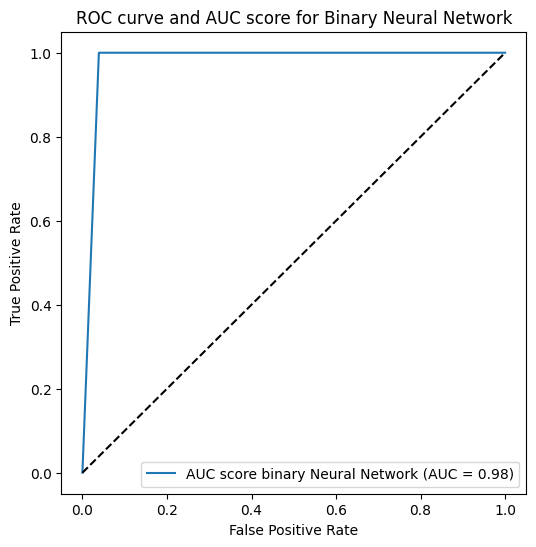

In [91]:
# Call the displayRocCurve function to display the ROC curve and the AUC score
estimator_name_bin = "AUC score binary Neural Network"
figsize_bin = (6, 6)

# Display the ROC curve and print out the AUC
functions_project.displayRocCurve(y_test, preds, estimator_name_bin, figsize_bin)
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.title("ROC curve and AUC score for Binary Neural Network")
plt.show()

### Loss curve

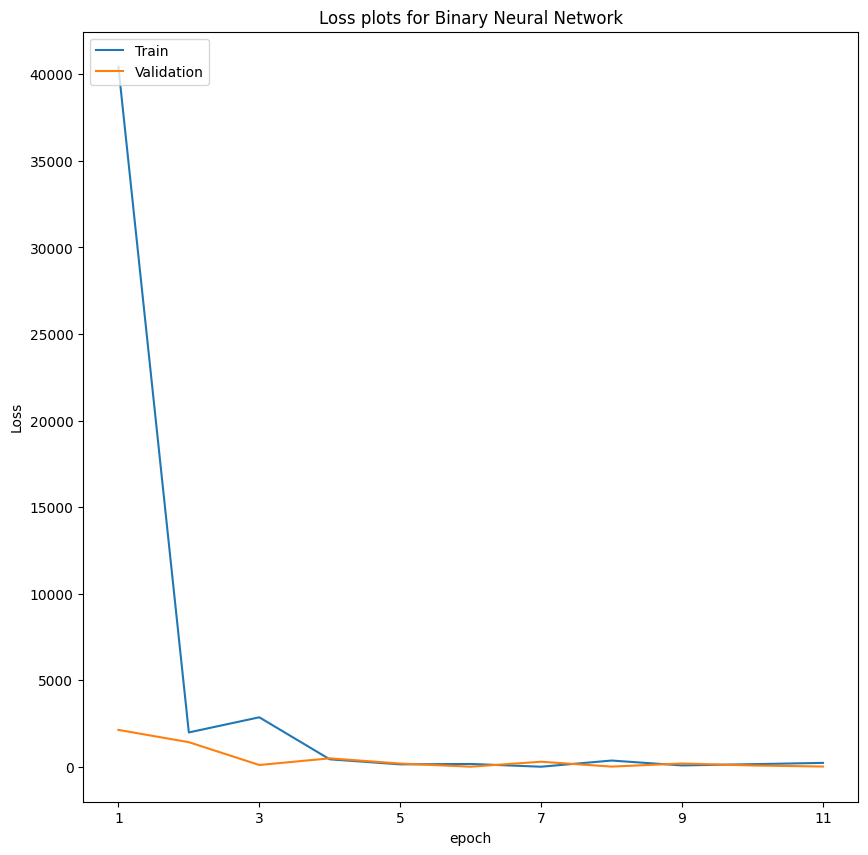

In [92]:
# Set parameters
y_loss = hist_bin.history['loss']
y_val_loss = hist_bin.history['val_loss']
title_bin_loss = "Loss plots for Binary Neural Network"
ylabel = "Loss"
figsize_bin = (10, 10)

# summarize history for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_loss, y_val_loss, title_bin_loss, ylabel, figsize_bin)

### Classification report

In [93]:
# Get the classification report
class_rep_bin = classification_report(y_test, pred_nn, target_names = labels_binary_nn)

print(class_rep_bin)

              precision    recall  f1-score   support

   No cancer       1.00      0.96      0.98        77
      Cancer       0.96      1.00      0.98        66

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



# Conclusion
Based on the results of the Neural Networks, we can conclude the following things:
- The recall score (a.k.a. True Negative Rate) for the binary predictions is 1.00. Although that is an amazing score, it could be less when the size of the data involved is larger. Nonetheless, it is expected that the results would still be very good.
- The accuracy score for the binary is 0.61. That is an ok score, but it is not the target we want to meet, which is 0.80. 
- For the regression model, we wanted to look at the Mean Absolute Error. It is quite difficult to estimate what a good MAE would be, but we can see from the graph that the MAE is not improving a lot after it has been run. Therefore, we can conclude that the model is not sufficient yet. 